In [1]:
%load_ext autoreload
%autoreload 2

if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    print(curr_file_path)
    sys.path.append(str(curr_file_path.parent))
    sys.path.append(os.path.join(str(curr_file_path.parent.parent.parent), 'fixed-point-finder'))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from torch.distributions.utils import logits_to_probs
from sklearn.decomposition import PCA
from agents.networks.a2c_rnn_split import A2CRNN
from agents.networks.gru_rnn import GRU_RNN
from plot_utils import plot_fps
from copy import deepcopy as copy
from nb_analysis_tools import load_numpy, load_compressed_data, parse_all_sessions, gen_alignment_chart, find_odor_site_trajectories_by_patch_type
from aux_funcs import compressed_write, logical_and, format_plot, compressed_read
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import r2_score
from numpy.linalg import norm
from imblearn.under_sampling import RandomUnderSampler


DATA_BASE_DIR = '../../results/rl_agent_outputs'
PATCH_TYPES_PER_ENV = 3
OBS_SIZE = PATCH_TYPES_PER_ENV + 1
ACTION_SIZE = 2
HIDDEN_SIZE = 128

# SUBNETWORK PARAMS
SUB_HIDDEN_SIZE = 32
SUB_INPUT_SIZE = 2
SUB_OUTPUT_SIZE = 1

plt.rcParams['font.family'] = 'Helvetica Light'

C:\Users\david.bell\work\favorably_connected\code\notebooks


In [2]:
# Load weights from given `load_path`
def load_network(load_path):
    
    network = A2CRNN(
        input_size=OBS_SIZE + ACTION_SIZE + 1,
        action_size=ACTION_SIZE,
        hidden_size=HIDDEN_SIZE,
        device='cpu',
        var_noise=0,
    )
    
    with torch.no_grad():
        saved_checkpoint = torch.load(os.path.join(DATA_BASE_DIR, load_path).replace('\\','/'), weights_only=False)
        if 'network_state_dict' in saved_checkpoint:
            network.load_state_dict(saved_checkpoint['network_state_dict'])
        else:
            network.load_state_dict(saved_checkpoint)
        network.eval()

    return network


# Load hidden states and behavior of network from `load path`
def load_hidden_and_behavior(load_path):
    data = load_numpy(os.path.join(DATA_BASE_DIR, load_path, 'hidden_state/*.npy').replace('\\','/'))
    data = np.transpose(data, [2, 1, 0])
    
    flattened_data = data.reshape(data.shape[0], data.shape[1] * data.shape[2], order='C')
    
    pca = PCA()
    pc_activities = pca.fit_transform(flattened_data.T)
    pc_activities = pc_activities.T.reshape(data.shape, order='C')
    
    all_session_data = parse_all_sessions(
        os.path.join(DATA_BASE_DIR, load_path, 'state'),
        30,
    )

    return data, pc_activities, all_session_data

In [3]:
weight_paths = [
    'he_init_with_noise_std_all_0p1_2025-04-19_23_17_25_922161_var_noise_0.0001_activity_weight_1/rnn_weights/01800.pth',
]

hidden_and_behavior_paths = [
    'test_he_init_0p1_922161_2025-04-22_09_01_08_731132_var_noise_0_activity_weight_0',
]

In [47]:
for i, (weight_path, hidden_and_behavior_path) in enumerate(zip(weight_paths, hidden_and_behavior_paths)):
    network = load_network(weight_path)
    acc_reward_vec_path = os.path.join(DATA_BASE_DIR, Path(weight_path).parents[1], 'stored_pcs_and_weights/rewards_seen_in_patch.pkl').replace('/', '\\')
    acc_reward_vec = compressed_read(acc_reward_vec_path)
    hidden_activities, pc_activities, all_session_data = load_hidden_and_behavior(hidden_and_behavior_path)

['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']


In [48]:
def extract_state_on_visual_cue(hidden_activity, session_data):
    visual_cue_went_high_mask = logical_and(
        session_data['obs'][:, 0] > 0,
        np.roll(session_data['obs'][:, 0], 1) < 1,
    )
    return hidden_activity[:, visual_cue_went_high_mask]

In [36]:
visual_cue_states = extract_state_on_visual_cue(hidden_activities[:, 0, :], all_session_data[0])

In [37]:
def cosine(u, v):
    return np.dot(u, v) / (norm(u)*norm(v))

In [38]:
cos_sims = []
for i in range(visual_cue_states.shape[1]):
    if i > 0:
        for j in range(i):
            cos_sims.append(cosine(visual_cue_states[:, i], visual_cue_states[:, j]))
        

In [39]:
print(np.mean(cos_sims))

0.98026544


In [10]:
flattened_ha = hidden_activities.reshape(hidden_activities.shape[0], hidden_activities.shape[1] * hidden_activities.shape[2], order='C')

print(flattened_ha.shape)

pca = PCA()
pc_activities = pca.fit_transform(flattened_ha.T)
pc_activities = pc_activities.T.reshape(hidden_activities.shape, order='C')

(128, 4200000)


Axes(0.125,0.11;0.775x0.77)


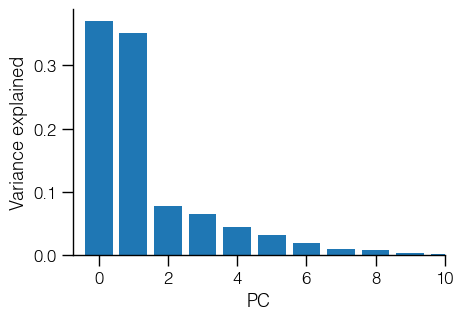

In [40]:
scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

explained_variance_ratios = pca.explained_variance_ratio_
axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')
format_plot(axs)

[<Axes: xlabel='Time'> <Axes: xlabel='Time', ylabel='PC'>]


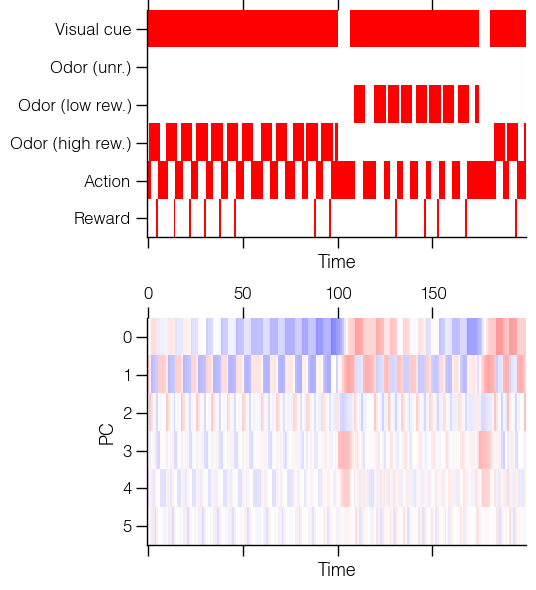

In [12]:
window = slice(1800, 2000)

scale = 1
fig, axs = plt.subplots(2, 1, figsize=(6 * scale, 6 * scale), sharex=True)
axs[1].matshow(pc_activities[:6, 0, window], cmap='bwr', vmin=-1, vmax=1, aspect=20)
axs[1].set_ylabel('PC')
axs[1].set_xlabel('Time')

inputs = np.concatenate([all_session_data[0]['obs'][window, :], all_session_data[0]['action'][window, np.newaxis], all_session_data[0]['reward'][window, np.newaxis]], axis=1).T
axs[0].matshow(inputs, cmap='bwr', vmin=-1, vmax=1, aspect=20)
axs[0].set_yticks(np.arange(6), ['Visual cue', 'Odor (unr.)', 'Odor (low rew.)', 'Odor (high rew.)', 'Action', 'Reward'])
axs[0].set_xlabel('Time')

format_plot(axs)
fig.tight_layout()

In [13]:
network_states = visual_cue_states.T
dummy_critic_states = torch.from_numpy(np.zeros_like(network_states))

network_states = torch.from_numpy(network_states)

In [14]:
def run_input_exp(network, inputs, proj_vec=None, t_steps=300, action_feedback=False, proj_vec_interventions=None):
    network.set_state(
        network_states,
        dummy_critic_states,
    )
    
    all_hidden_out = torch.empty((t_steps, visual_cue_states.shape[0], visual_cue_states.shape[1]))
    action_probs = torch.empty((t_steps, ACTION_SIZE, visual_cue_states.shape[1]))
    action_probs_totals = torch.zeros((t_steps, ACTION_SIZE, visual_cue_states.shape[1]))
    
    for i in range(t_steps):
        if proj_vec_interventions is not None:
            hidden = network.hidden_states.cpu()
            hidden += (proj_vec_interventions[i] * proj_vec)
            network.hidden_states = hidden

        action, value, hidden_out = network.forward(inputs[i, ...])
        all_hidden_out[i, ...] = hidden_out.T
        action_logits = network.action_arm(hidden_out[:, :HIDDEN_SIZE])
        action_logits -= action_logits.logsumexp(dim=-1, keepdim=True)
        action_probs[i, ...] = logits_to_probs(action_logits).T

        action_probs_totals[i, ...] += action_probs[i, ...]
        if i > 0:
            action_probs_totals[i, ...] += action_probs_totals[i-1, ...]

        if action_feedback:
            action = np.argmax(action_probs[i, ...].detach(), axis=0)
            inputs[i, np.arange(action.shape[0]), OBS_SIZE + action] = 1

    return {
        'all_hidden_out': all_hidden_out.detach(),
        'action_probs': action_probs.detach(),
        'action_probs_totals': action_probs_totals.detach(),
    }

def run_mult_input_exps(network, input_set, proj_vec, proj_vec_intervention_set, t_steps=300, action_feedback=False):
    all_data = []
    for i in range(input_set.shape[0]):
        inputs = input_set[i, ...]
        proj_vec_interventions = proj_vec_intervention_set[i, ...]
        d = run_input_exp(
            network,
            inputs,
            proj_vec=proj_vec,
            proj_vec_interventions=proj_vec_interventions,
            t_steps=t_steps,
            action_feedback=action_feedback,
        )
        all_data.append(d)
    return all_data

def plot_exp(network, inputs, proj_vec=None, t_steps=300, action_feedback=False, selected_trial=0, window=None, proj_vec_interventions=None):
    d = run_input_exp(
        network,
        inputs,
        proj_vec=proj_vec,
        t_steps=t_steps,
        action_feedback=action_feedback,
        proj_vec_interventions=proj_vec_interventions,
    )
    
    scale = 0.8
    fig, axs = plt.subplots(6, 1, figsize=(9 * scale, 11 * scale), sharex=True)
    axs[1].matshow(d['all_hidden_out'][..., selected_trial].T, aspect='auto', cmap='bwr', vmin=-1, vmax=1)

    axs[2].matshow(pca.transform(d['all_hidden_out'][..., selected_trial]).T[:6, :], aspect='auto', cmap='bwr', vmin=-1, vmax=1)

    axs[0].matshow(inputs[:, 0, np.array([0, 1, 2, 3, 4, 5, 6])].T, aspect='auto', cmap='bwr', vmin=-1, vmax=1)
        
    m = np.abs(d['action_probs']).max()
    axs[3].matshow(d['action_probs'][..., selected_trial].T, aspect='auto', cmap='bwr', vmin=-1, vmax=1)

    if proj_vec is not None:
        axs[4].matshow(np.dot(proj_vec, d['all_hidden_out'][..., selected_trial].T)[np.newaxis, :], aspect='auto', cmap='bwr', vmin=-1, vmax=1)

    axs[5].plot(np.arange(t_steps), d['action_probs_totals'][:, 0, selected_trial])

    if window:
        axs[0].set_xlim(*window)

    axs[0].set_yticks(np.arange(7), ['Visual cue', 'Odor (unr.)', 'Odor (low rew.)', 'Odor (high rew.)', 'Stay', 'Run', 'Reward'])
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Input')
    
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Unit activity\n(RNN)')

    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('PC')
    
    axs[3].set_yticks(np.arange(2), ['Stay', 'Leave'])

    axs[4].set_yticks(np.arange(1), ['Acc. reward\nprojection'])
    format_plot(axs)
    fig.tight_layout()

[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


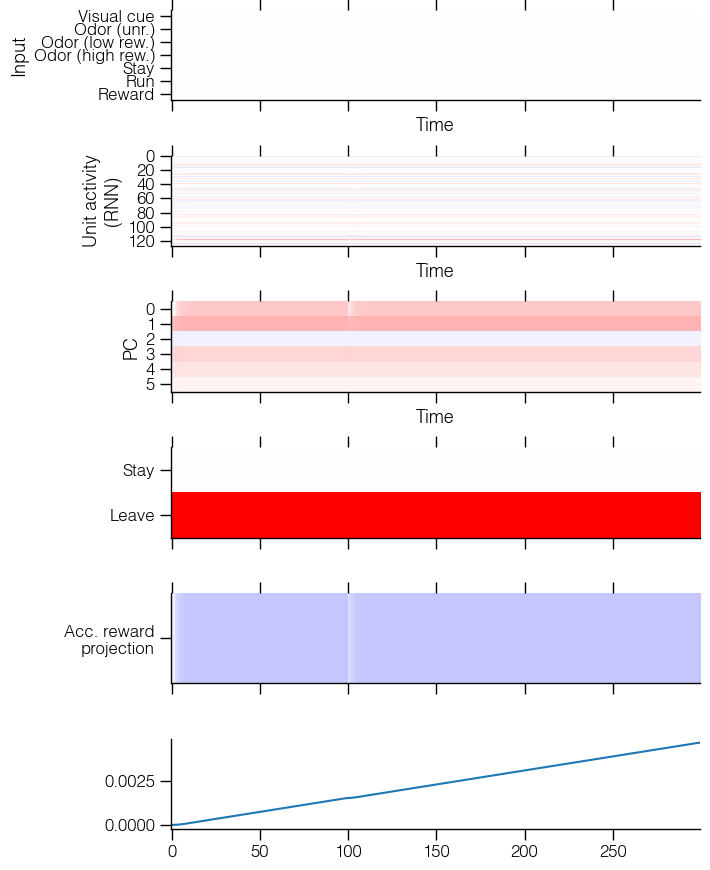

In [15]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
p = torch.zeros(t_steps)
p[100] = 0.25
plot_exp(network, inputs, acc_reward_vec, t_steps=t_steps, proj_vec_interventions=p)

[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


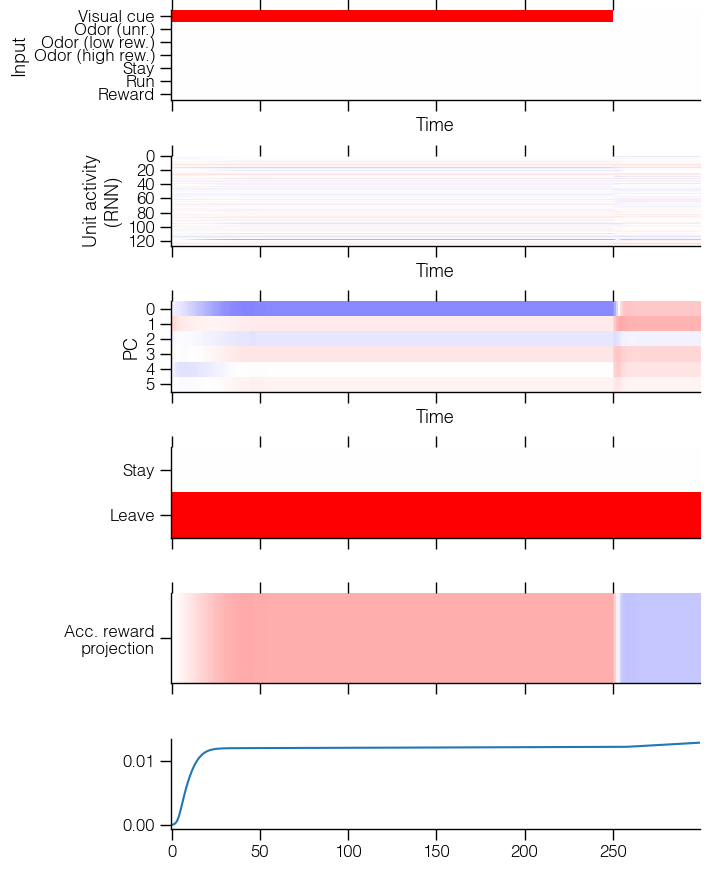

In [16]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
plot_exp(network, inputs, acc_reward_vec, t_steps)

[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


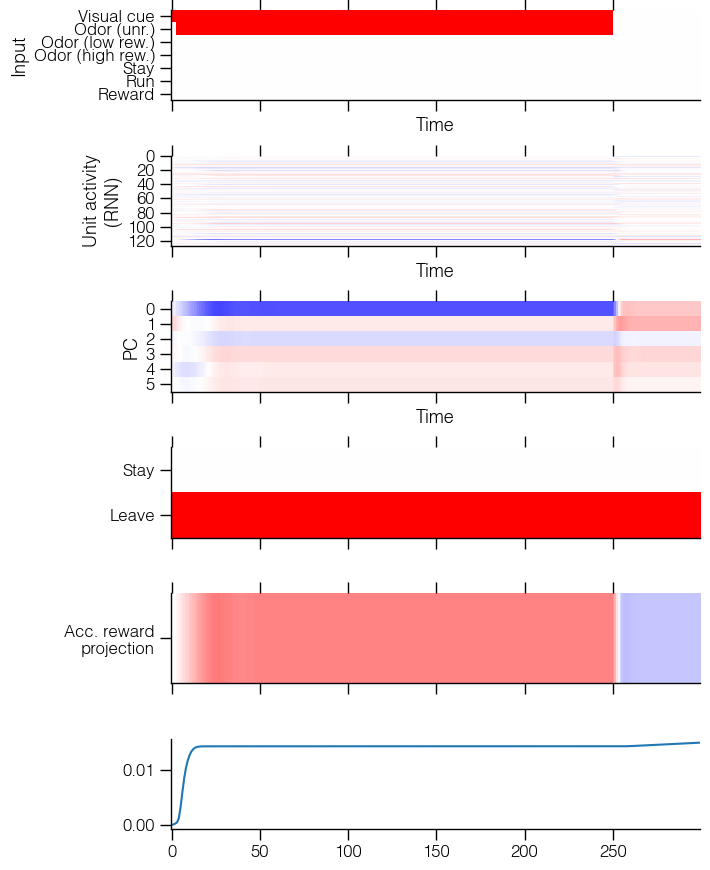

In [17]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[3:250, :, 1] = 1
plot_exp(network, inputs, acc_reward_vec, t_steps=t_steps, action_feedback=False)

[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


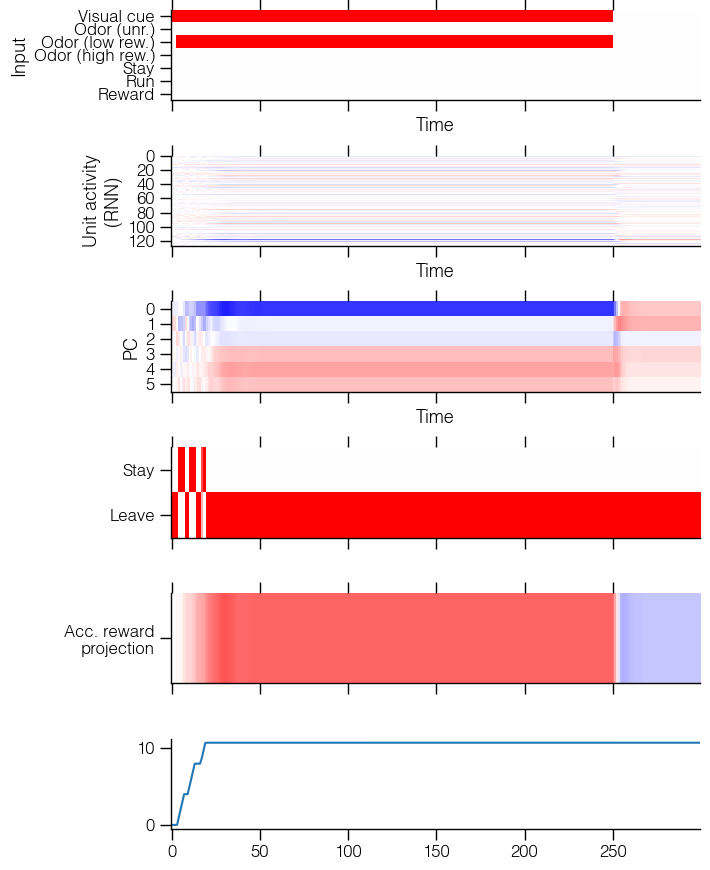

In [18]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[3:250, :, 2] = 1
plot_exp(network, inputs, acc_reward_vec, t_steps=t_steps, action_feedback=False)

[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


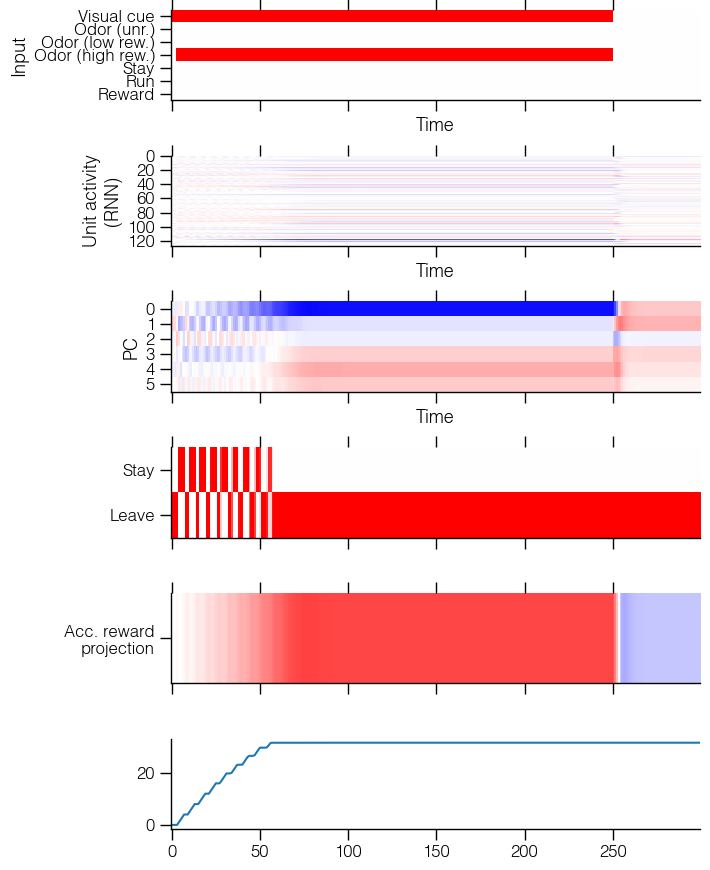

In [19]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[3:250, :, 3] = 1
plot_exp(network, inputs, acc_reward_vec, t_steps=t_steps, action_feedback=False)

[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


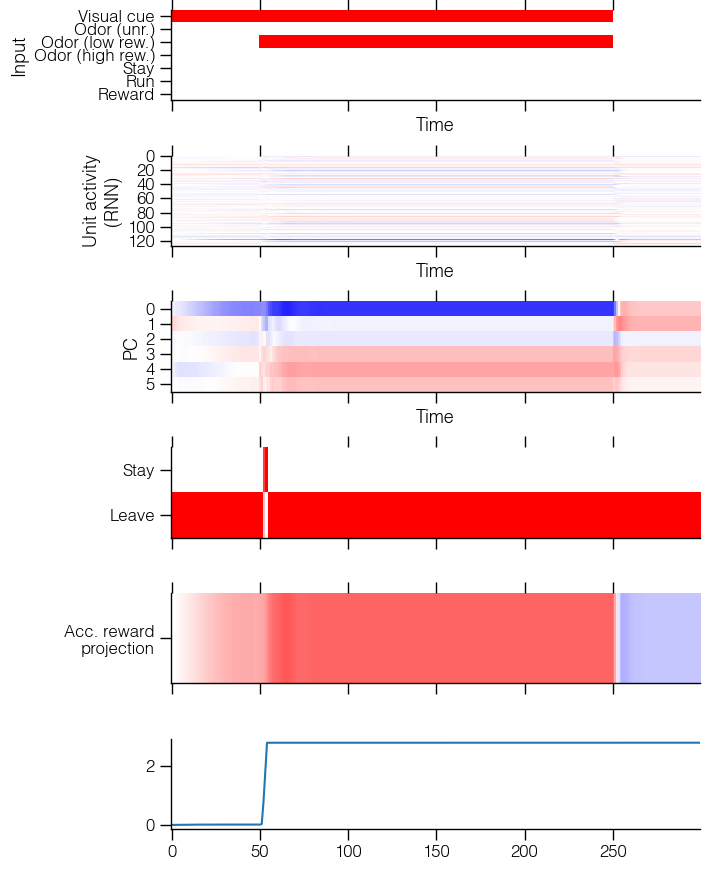

In [20]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[50:250, :, 2] = 1
plot_exp(network, inputs, acc_reward_vec, t_steps=t_steps, action_feedback=False)

[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


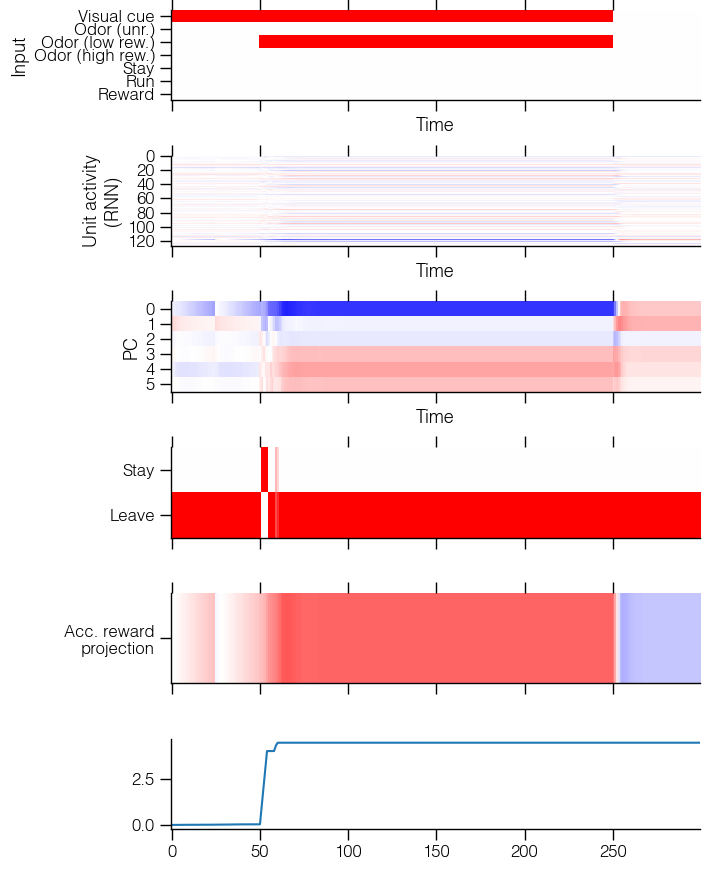

In [50]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[50:250, :, 2] = 1
p = torch.zeros(t_steps)
p[25] = -0.5
plot_exp(network, inputs, acc_reward_vec, t_steps=t_steps, proj_vec_interventions=p)

[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


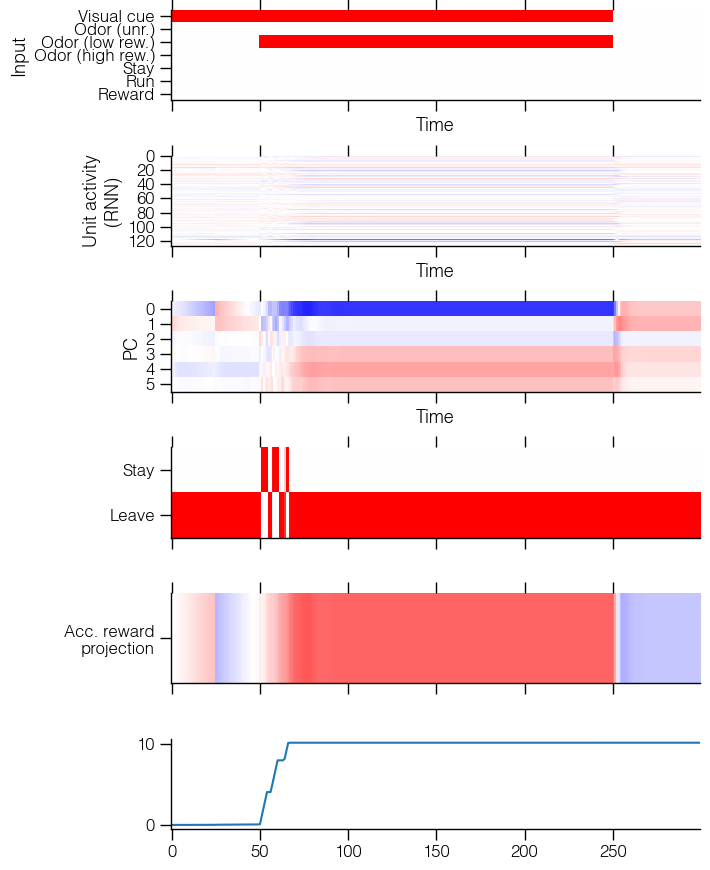

In [51]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[50:250, :, 2] = 1
p = torch.zeros(t_steps)
p[25] = -1
plot_exp(network, inputs, acc_reward_vec, t_steps=t_steps, proj_vec_interventions=p)

[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


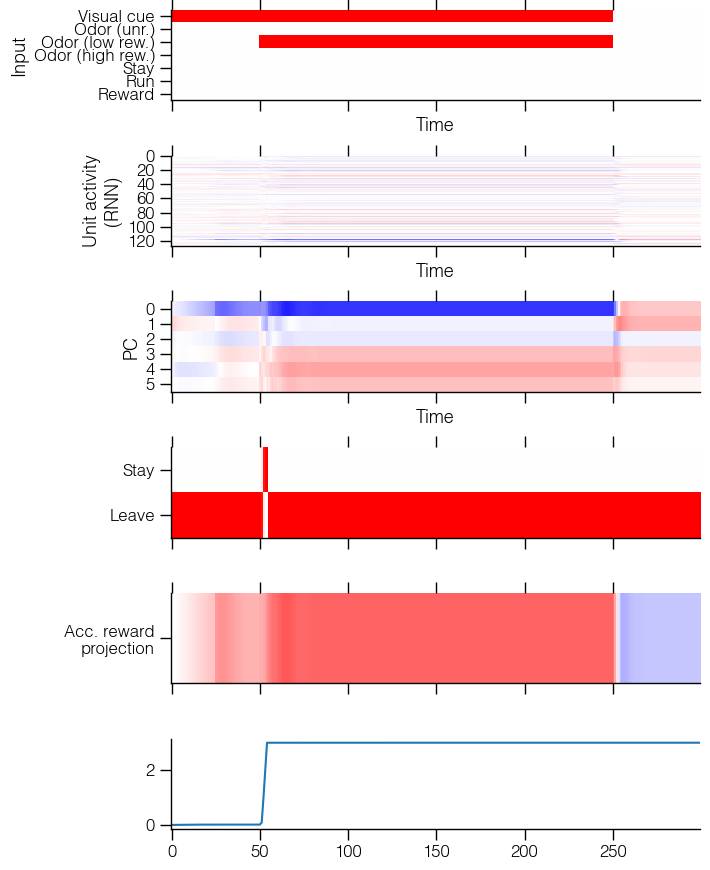

In [25]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[50:250, :, 2] = 1
p = torch.zeros(t_steps)
p[25] = 0.25
plot_exp(network, inputs, acc_reward_vec, t_steps=t_steps, proj_vec_interventions=p)

[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


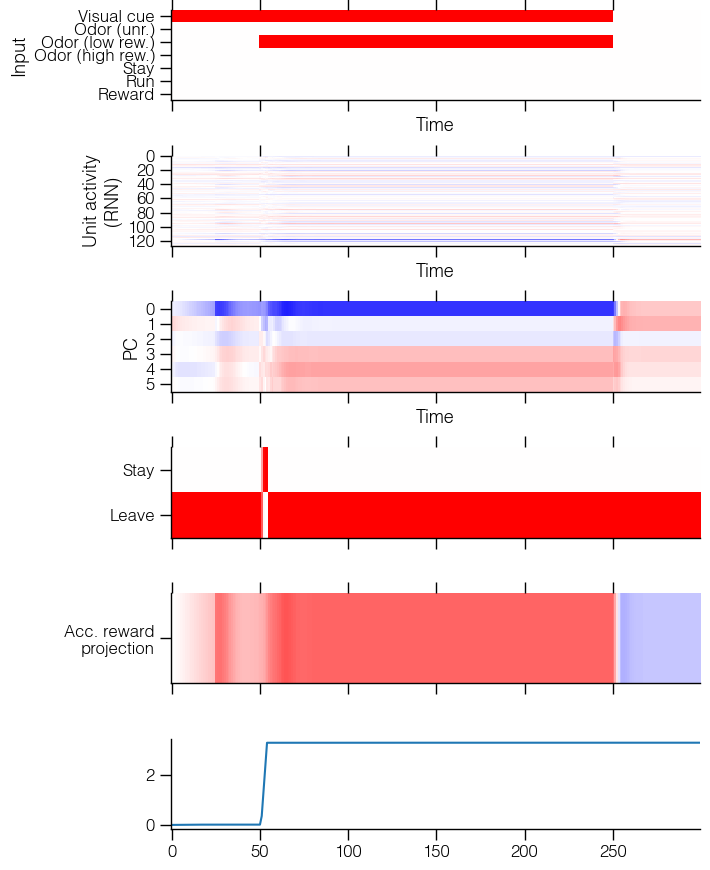

In [26]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[50:250, :, 2] = 1
p = torch.zeros(t_steps)
p[25] = 0.5
plot_exp(network, inputs, acc_reward_vec, t_steps=t_steps, proj_vec_interventions=p)

[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


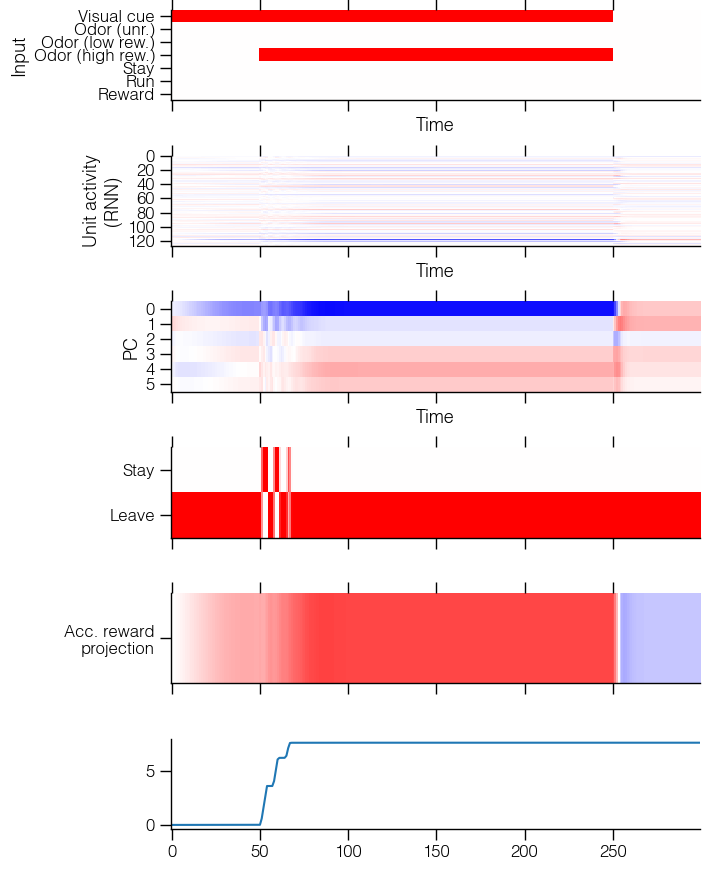

In [27]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[50:250, :, 3] = 1
plot_exp(network, inputs, acc_reward_vec, t_steps=t_steps)

[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


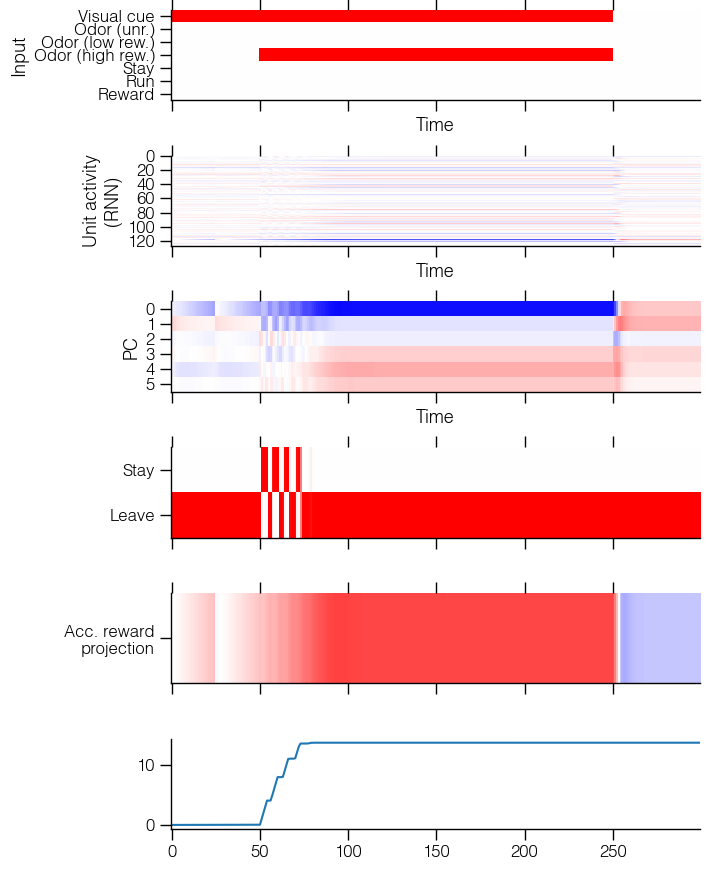

In [58]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[50:250, :, 3] = 1
p = torch.zeros(t_steps)
p[25] = -0.5
plot_exp(network, inputs, acc_reward_vec, t_steps=t_steps, proj_vec_interventions=p)

[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


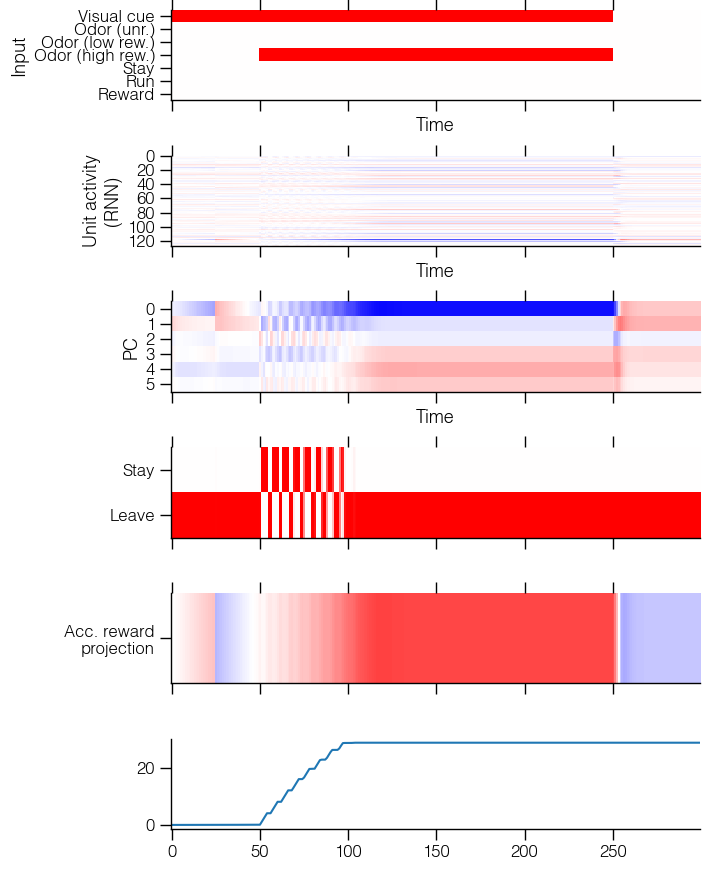

In [30]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[50:250, :, 3] = 1
p = torch.zeros(t_steps)
p[25] = -1
plot_exp(network, inputs, acc_reward_vec, t_steps=t_steps, proj_vec_interventions=p)

[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


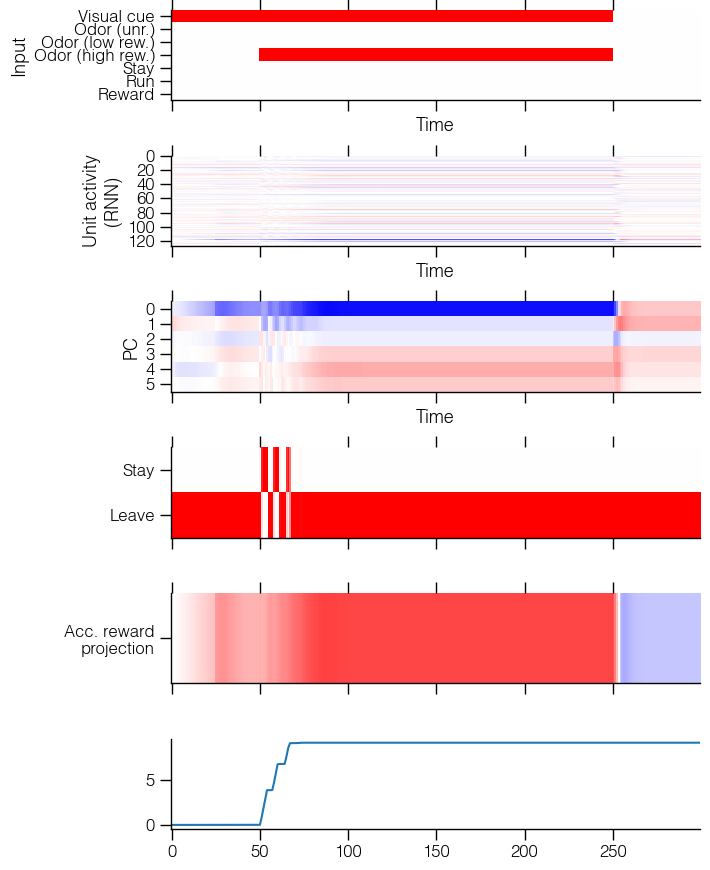

In [59]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[50:250, :, 3] = 1
p = torch.zeros(t_steps)
p[25] = 0.25
plot_exp(network, inputs, acc_reward_vec, t_steps=t_steps, proj_vec_interventions=p)

[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


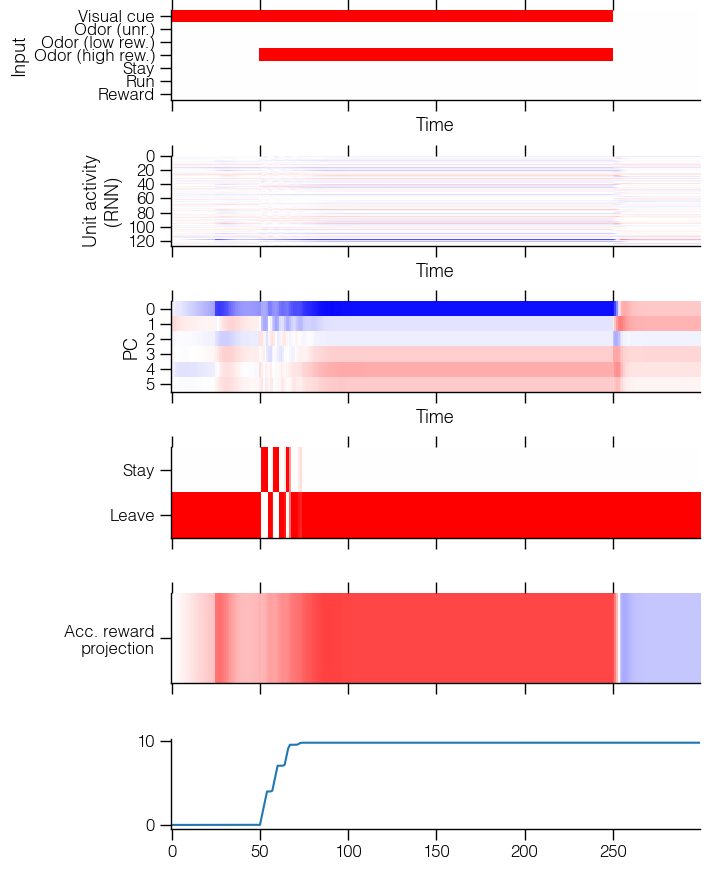

In [60]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[50:250, :, 3] = 1
p = torch.zeros(t_steps)
p[25] = 0.5
plot_exp(network, inputs, acc_reward_vec, t_steps=t_steps, proj_vec_interventions=p)

In [70]:
t_steps = 300
pert_sizes = np.array([-0.5, -0.4, -0.3, -0.2, -0.1, 0]) * 2
n_exps = len(pert_sizes)
inputs = torch.zeros(n_exps, t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:, :250, :, 0] = 1
inputs[:, 50:250, :, 2] = 1
p = torch.zeros(n_exps, t_steps)
for i, ps in enumerate(pert_sizes):
    p[i, 25] = ps
data = run_mult_input_exps(network, inputs, acc_reward_vec, t_steps=t_steps, proj_vec_intervention_set=p)

torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
Axes(0.125,0.11;0.62x0.77)


C:\Users\david.bell\AppData\Local\Temp\ipykernel_10808\1508281176.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(color_scheme, n)  # Discretize colormap into n colors


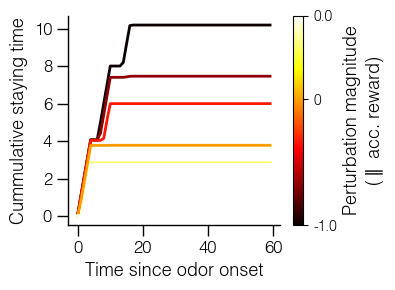

In [71]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 3 * scale), sharex=True)
color_scheme = 'hot'

n = inputs.shape[0]
cmap = mpl.cm.get_cmap(color_scheme, n)  # Discretize colormap into n colors
colors = [cmap(i) for i in range(n)]
 
for i, d in enumerate(data):
    print(d['action_probs_totals'].shape)
    axs.plot(np.arange(110 - 50), d['action_probs_totals'][50:110, 0, 0], lw=2, color=colors[i])

norm = mpl.colors.Normalize(vmin=0, vmax=n - 1)
sm = mpl.cm.ScalarMappable(cmap=color_scheme, norm=norm)
sm.set_array([])  # required for colorbar, even if unused
cbar = fig.colorbar(sm, ax=axs, ticks=[0, int(n/2), n-1])
cbar.set_ticklabels([pert_sizes[0], 0, pert_sizes[-1]])
cbar.set_label('Perturbation magnitude\n' + r'($\parallel$ acc. reward)', fontsize=13)

axs.set_ylabel('Cummulative staying time')
axs.set_xlabel('Time since odor onset')
# axs.set_ylim(0, 35)
format_plot(axs)
fig.tight_layout()

Axes(0.125,0.11;0.775x0.77)


C:\Users\david.bell\AppData\Local\Temp\ipykernel_10808\2985963865.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(color_scheme, n)  # Discretize colormap into n colors


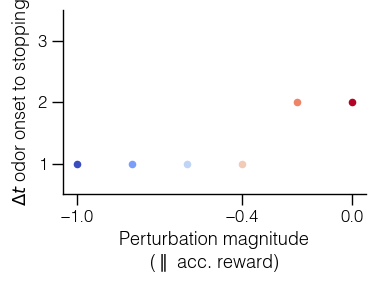

In [73]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 3 * scale), sharex=True)
color_scheme = 'coolwarm'

n = inputs.shape[0]
cmap = mpl.cm.get_cmap(color_scheme, n)  # Discretize colormap into n colors
colors = [cmap(i) for i in range(n)]
 
for i, d in enumerate(data):
    stay_prob = d['action_probs'][50:110, 0, 0]
    first_moment_staying = np.arange(len(stay_prob))[stay_prob > 0.5][0]
    
    axs.scatter(pert_sizes[i], first_moment_staying, color=colors[i], s=20)
pert_sizes_summary = [pert_sizes[0], pert_sizes[int(n/2)], pert_sizes[-1]]
axs.set_xticks(pert_sizes_summary)
axs.set_ylim(0.5, 3.5)

# norm = mpl.colors.Normalize(vmin=0, vmax=n - 1)
# sm = mpl.cm.ScalarMappable(cmap=color_scheme, norm=norm)
# sm.set_array([])  # required for colorbar, even if unused
# cbar = fig.colorbar(sm, ax=axs, ticks=range(n))
# cbar.set_ticklabels([-0.5, -0.25, 0, 0.25, 0.5])
# cbar.set_label('Perturbation magnitude\n' + r'($\parallel$ acc. reward)', fontsize=13)

axs.set_ylabel(r'$\Delta t$ odor onset to stopping')
axs.set_xlabel('Perturbation magnitude\n' + r'($\parallel$ acc. reward)')
format_plot(axs)
fig.tight_layout()

In [74]:
t_steps = 300
pert_sizes = np.array([-0.5, -0.4, -0.3, -0.2, -0.1, 0]) * 2
n_exps = len(pert_sizes)
inputs = torch.zeros(n_exps, t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:, :250, :, 0] = 1
inputs[:, 50:250, :, 3] = 1
p = torch.zeros(n_exps, t_steps)
for i, ps in enumerate(pert_sizes):
    p[i, 25] = ps
data = run_mult_input_exps(network, inputs, acc_reward_vec, t_steps=t_steps, proj_vec_intervention_set=p)

torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
torch.Size([300, 2, 202])
Axes(0.125,0.11;0.62x0.77)


C:\Users\david.bell\AppData\Local\Temp\ipykernel_10808\2107256624.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(color_scheme, n)  # Discretize colormap into n colors


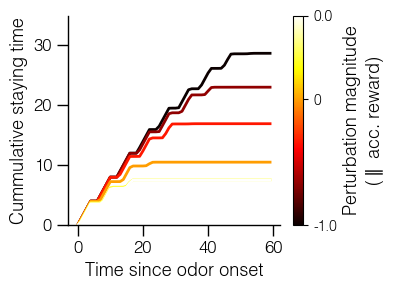

In [75]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 3 * scale), sharex=True)
color_scheme = 'hot'

n = inputs.shape[0]
cmap = mpl.cm.get_cmap(color_scheme, n)  # Discretize colormap into n colors
colors = [cmap(i) for i in range(n)]
 
for i, d in enumerate(data):
    print(d['action_probs_totals'].shape)
    axs.plot(np.arange(110 - 50), d['action_probs_totals'][50:110, 0, 0], lw=2, color=colors[i])

norm = mpl.colors.Normalize(vmin=0, vmax=n - 1)
sm = mpl.cm.ScalarMappable(cmap=color_scheme, norm=norm)
sm.set_array([])  # required for colorbar, even if unused
cbar = fig.colorbar(sm, ax=axs, ticks=[0, int(n/2), n-1])
cbar.set_ticklabels([pert_sizes[0], 0, pert_sizes[-1]])
cbar.set_label('Perturbation magnitude\n' + r'($\parallel$ acc. reward)', fontsize=13)

axs.set_ylabel('Cummulative staying time')
axs.set_xlabel('Time since odor onset')
axs.set_ylim(0, 35)
format_plot(axs)
fig.tight_layout()

Axes(0.125,0.11;0.775x0.77)


C:\Users\david.bell\AppData\Local\Temp\ipykernel_10808\2985963865.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(color_scheme, n)  # Discretize colormap into n colors


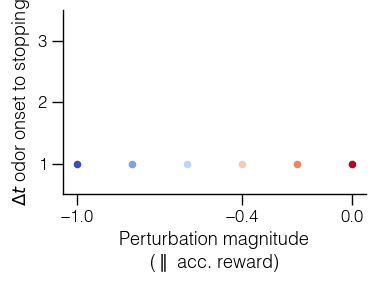

In [76]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 3 * scale), sharex=True)
color_scheme = 'coolwarm'

n = inputs.shape[0]
cmap = mpl.cm.get_cmap(color_scheme, n)  # Discretize colormap into n colors
colors = [cmap(i) for i in range(n)]
 
for i, d in enumerate(data):
    stay_prob = d['action_probs'][50:110, 0, 0]
    first_moment_staying = np.arange(len(stay_prob))[stay_prob > 0.5][0]
    
    axs.scatter(pert_sizes[i], first_moment_staying, color=colors[i], s=20)
pert_sizes_summary = [pert_sizes[0], pert_sizes[int(n/2)], pert_sizes[-1]]
axs.set_xticks(pert_sizes_summary)
axs.set_ylim(0.5, 3.5)

# norm = mpl.colors.Normalize(vmin=0, vmax=n - 1)
# sm = mpl.cm.ScalarMappable(cmap=color_scheme, norm=norm)
# sm.set_array([])  # required for colorbar, even if unused
# cbar = fig.colorbar(sm, ax=axs, ticks=range(n))
# cbar.set_ticklabels([-0.5, -0.25, 0, 0.25, 0.5])
# cbar.set_label('Perturbation magnitude\n' + r'($\parallel$ acc. reward)', fontsize=13)

axs.set_ylabel(r'$\Delta t$ odor onset to stopping')
axs.set_xlabel('Perturbation magnitude\n' + r'($\parallel$ acc. reward)')
format_plot(axs)
fig.tight_layout()

In [39]:
def append_pulsed_input(inputs, index, onset, n_cycles, on_period, off_period):
    v = np.empty(int(n_cycles * (on_period + off_period)))
    for c in range(n_cycles):
        period_start = onset + (on_period + off_period) * c
        inputs[period_start : period_start + on_period, :, index] = 1
        inputs[period_start + on_period : period_start + on_period + off_period, :, index] = 0